# Data Mining with Professor Sloan Week 9

## Maggie Boles

### 11/7/2025

#### From Blackboard: Using the hotel reviews dataset, create a sentiment analysis model using at least one of the methods described this week (you’re welcome to create more than one). Be sure to have three data slices - train, validation, and test as specified in the text. 
    Note that the "sentiment" is expressed in the Is_Response, which should be label encoded (0=happy, 1=not happy). If you're not familiar with label encoding, check this out:
    Categorical encoding is a process of converting categories to numbers. This article explains the difference between one hot encoding vs label encoding.
    Analytics Vidhya
    NOTE: the author imports a contractions package, which failed for me. You're encouraged to use your text normalizer (which has its own contractions.py) from Week 4.
    A few other notes:
    TensorFlow has had a new release, which means that if you install TF 2.0, some things won't work. You have some choices:
    Install TF 1.0
    If you install TF 2.0, use import tensorflow.compat.v1 as tf
    In both the book (page 647), the author uses np.vectorize on the cleansed train, validation, and test text. Don't do this.
    The author sets TOTAL_STEPS=1500 and STEP_SIZE=100 in the Model Training section of the code. Unless you are working in the cloud or have a mega powerful PC, don't set those values that high. (Your model will take many hours to train.) Instead, use TOTAL_STEPS=100 and STEP_SIZE=10. While the resulting model won't be as accurate, it'll still do the trick for this assignment (and even with the lower values, expect the training to take 20-30 minutes or more if you have a slow PC).
    Be sure to document your thought process and interpretation of the results within Markdown in your Notebook.

Dataset shape: (38932, 5)

First few rows:
   User_ID                                        Description  \
0  id10326  The room was kind of clean but had a VERY stro...   
1  id10327  I stayed at the Crown Plaza April -- - April -...   
2  id10328  I booked this hotel through Hotwire at the low...   
3  id10329  Stayed here with husband and sons on the way t...   
4  id10330  My girlfriends and I stayed here to celebrate ...   

        Browser_Used Device_Used Is_Response  
0               Edge      Mobile   not happy  
1  Internet Explorer      Mobile   not happy  
2            Mozilla      Tablet   not happy  
3   InternetExplorer     Desktop       happy  
4               Edge      Tablet   not happy  

Class distribution in Is_Response:
Is_Response
happy        0.681213
not happy    0.318787
Name: proportion, dtype: float64
Sample raw text: The room was kind of clean but had a VERY strong smell of dogs. Generally below average but ok for a overnight stay if you're not too fussy. W

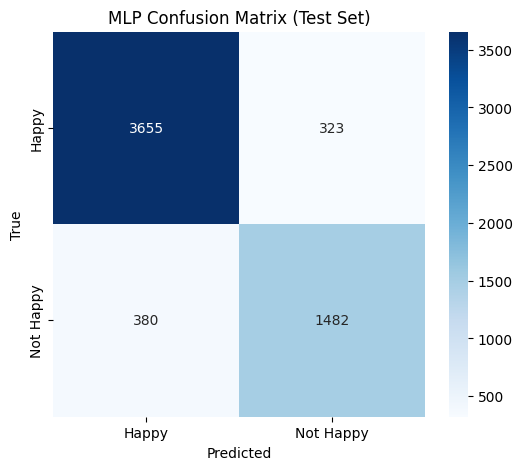

In [14]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Load the dataset
df = pd.read_csv('hotel_reviews.csv')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nClass distribution in Is_Response:")
print(df['Is_Response'].value_counts(normalize=True))

# Basic contractions dictionary 
contractions = {
    "ain't": "am not",
    "can't": "cannot",
    "won't": "will not",
    # Add more as needed...
}

#text preprocessing 
def expand_contractions(text):
    for word in contractions:
        text = re.sub(r"\b" + word + r"\b", contractions[word], text.lower())
    return text

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def normalize_text(text):
    if pd.isna(text):
        return ""
    # Expand contractions
    text = expand_contractions(str(text))
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

# Apply normalization
print("Sample raw text:", df['Description'].iloc[0])
df['cleaned_text'] = df['Description'].apply(normalize_text)
print("Sample cleaned text:", df['cleaned_text'].iloc[0])

# Label Encoding and Data Splitting 
print("Unique values in 'Is_Response':", df['Is_Response'].unique())

# Label encoding for Happy and Not Happy
label_mapping = {'happy': 0, 'not happy': 1}
df['label'] = df['Is_Response'].map(label_mapping)

# Drop any unmapped values
df = df.dropna(subset=['label']).copy()
df['label'] = df['label'].astype(int)

X = df['cleaned_text']
y = df['label']

# Stratified split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Train class balance: {np.bincount(y_train)}")
print()

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2,
    max_df=0.95
)

# Fit on TRAINING data  
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
X_test_vec  = vectorizer.transform(X_test)

print("TF-IDF Vocabulary size:", len(vectorizer.vocabulary_))
print("X_train_vec shape:", X_train_vec.shape)

# Model Eval
def evaluate(y_true, y_pred, name):
    print(f"\n{name} Results:")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score : {f1_score(y_true, y_pred):.4f}")

#Regression Model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_vec, y_train)

lr_val_pred = lr_model.predict(X_val_vec)
lr_test_pred = lr_model.predict(X_test_vec)

evaluate(y_val, lr_val_pred, "Logistic Regression - Validation")
evaluate(y_test, lr_test_pred, "Logistic Regression - Test")

# MLP Classifier
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42,
    verbose=False
)

mlp_model.fit(X_train_vec, y_train)

mlp_val_pred = mlp_model.predict(X_val_vec)
mlp_test_pred = mlp_model.predict(X_test_vec)

evaluate(y_val, mlp_val_pred, "MLP - Validation")
evaluate(y_test, mlp_test_pred, "MLP - Test")

# Confusion Matrix for MLP
cm = confusion_matrix(y_test, mlp_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Happy', 'Not Happy'],
            yticklabels=['Happy', 'Not Happy'])
plt.title('MLP Confusion Matrix (Test Set)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

##### This week as we dive into sentiment analysis we are using the Hotel reviews dataset to train a model. From our prepocessing we can see we are almost double in happy reviews to unhappy reviews, we don't want the model to predict happy for the whole dataset, this would give a lot of false positives. So the Not happy predictions will be important as we build our model. A misflagged happy as not happy would not be a detriment to the model, where a misflagged not happy as happy would be an issue. 

##### In the preprocess we clean out text to expand contractions, lowercase the whole text, remove punctuation, apply tokenization, remove stop words, lemmatization and then rejoin. This allows us to remove noise and keep the sentiment. 

##### For the train/val/split, stratifications allows us to keep the split similar to the whole document. We have a 68% Happy and 32% Unhappy, so we keep our training test numbers on a percentage of the data but in proportion to the whole, this is true for the VAL portion of data as well. So for the data we would have a 68 to 32 weight to the Train, Val and Test data we apply, ensuring we keep the weights the same, but still get to explore the whole data. 70% for train(27,251 samples), 15% for Val(5,841 samples), and 15% for Test(5,840 samples). And taking the whole of happy and unhappy and dividing into each of them the correct percentages to help the model from overfitting, keeping a balanced exposure, and bias. Each of these are important to have a functioning model that will actually do the thing, and not just simply give us a perfect model that doesn't have depth. 

##### From our outputs from the model we can see that the MLP gives us better Recall and F-1 scores in the test and validation portion of our observations. A little variance between accuracy and precision between the two models, but with the recall being high we get fewer unhappy guests missed which would be very important for hotel management or stakeholders. If we were to convey this in our model we could flag some of the negative reviews for management, which would help to monitor the model on issues. With a high accuracy we have a high reliability. With the 79% recall we miss some guests that were unhappy, but again we could batch flag those for management. We would have trustworthy results for hotel reviews. 

##### From here we can retrain and expand online learning for vocabulary, we used TF-IDF we could potentially lean on other NLP processes here to try and refine the ingestion during training, val, and test portions of the model. 